## Backtesting



In this Notebook we study backtesting, we will use the backtesting library to automize the procedure and TALIB library for Technical indicators

We explore different types of strategies naive, sophisticated, and historical strategies, the idea is to compare strategies and find the one that works with most stocks based on the win_rate metric.

The goal is to create and explore tools that can help to understand stock behavior and find an efficient way to generalize it.

NB: this Notebook is made for scientific purposes to create a survey for backtesting with python and not to produce profitability.

In [1]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross
from backtesting.test import SMA,GOOG
from IPython.core.display import display, HTML
import pandas as pd 
import talib
import glob
from os import listdir
from os.path import isfile, join
import numpy as np
import itertools
import datetime as dt
import pickle
import json
import ta
from additional_indicators import supertrend,Tenkan_Sen, Kijun_Sen, Senkou_SpanA, Senkou_SpanB, Chikou_Span

c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zakaria Bouchegoura\AppData\Local\Temp\ipykernel_21088\774219638.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Global Var :

In [2]:
cash=1000
comission=.002
PATH = r'C:\Users\Zakaria Bouchegoura\Desktop\Nouveau dossier (5)\archive\stock_market_data\nasdaq\csv' 

### Loading All Stock Market :

For correct usage of Backtest.lib its require to put the index of the dataset as Date.time type.

In [3]:
# getting path's of all datasets
datasets_files = glob.glob(PATH + "/*.csv")

datasets = {} # dictionary to save each stock-market dataset by its Index

for filename in datasets_files:
    stock_name=filename.split("\\")[-1][:-4] #getting the Index of the stock
    df = pd.read_csv(filename, index_col=None, header=0)
    datetime_series = pd.to_datetime(df['Date'],dayfirst=True)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2=df.set_index(datetime_index)
    df2["year"]=datetime_index.year
    df2.drop('Date',axis=1,inplace=True)
    df2=df2.dropna()
    datasets[stock_name]=df2

In [4]:
# adding to the global environment, global variables of each stock market called by its stock index
locals().update(datasets)

In [5]:
#Example: if you want any to view the dataset of Apple you need just to type it indice "AAPL"
AAPL # Hooray !

,Low,Open,Volume,High,Close,Adjusted Close,year
1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348,0.100178,1980
1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652,0.094952,1980
1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723,0.087983,1980
1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513,0.090160,1980
1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862,0.092774,1980
...,...,...,...,...,...,...,...
2022-05-31,146.839996,149.070007,103718400,150.660004,148.839996,148.839996,2022
2022-06-01,147.679993,149.899994,74286600,151.740005,148.710007,148.710007,2022
2022-06-02,146.860001,147.830002,72348100,151.270004,151.210007,151.210007,2022
2022-06-03,144.460007,146.899994,88471400,147.970001,145.380005,145.380005,2022


## Defining Strategies

##### List of Strategies :

1-SMA Croos (simple strategie) : based on two moving average indicator

2-bollinger bands strategy (simple strategie)  : based on one bollinger bands indicator

3-bollinger bands + RSI strategy : based on one bollinger bands and one RSI indicator

4-SuperTrend : based on supertrend and exponential moving average indicator

5-Tradepro : based on three exponential moving average, Stochastic, Average True Range indicator

6-Ichimuko : the notorious Ichimuko strategy with little twist

##### 1-SMA Croos

In [6]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n1)
        self.sma2 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()

##### 2-bollinger bands

In [7]:
class BBand(Strategy):
    n = 20
    wn=2

    def init(self):
        close = self.data.Close
        self.upper,_,self.down  =self.I(talib.BBANDS, close, self.n, self.wn) 
    
    def next(self):
        if crossover(self.data.Close, self.down):
            self.buy()
        elif crossover(self.upper, self.data.Close):
            self.sell()

##### 3-bollinger bands + RSI

In [8]:
class BBand_RSI(Strategy):
    n = 30
    wn=2
    tp=13

    def init(self):
        close = self.data.Close
        self.upper,_,self.down  =self.I(talib.BBANDS, close, self.n, self.wn) 
        self.rsi=self.I(talib.RSI,close,self.tp)
    
    def next(self):
        if (crossover(self.data.Close, self.down) and
            self.rsi<30):
            self.buy()
        elif (crossover(self.upper, self.data.Close) and
                self.rsi>70):
            self.sell()

##### 4-SuperTrend

In [9]:
class SuperTrend(Strategy):

    length=12
    multiplier=3
    t_period=200

    def init(self):
        
        close=self.data.Close
        high=self.data.High
        low=self.data.Low

        self.super,self.upper,self.down =self.I(supertrend,pd.Series(high),pd.Series(low),pd.Series(close),self.length,self.multiplier)
        self.DEMA_200=self.I(talib.DEMA,close,self.t_period)

    def next(self):

        price=self.data.Close
        
        if (self.DEMA_200>price and 
            crossover(self.super,price)):
            self.buy()
        elif (crossover(price,self.super)):
            self.sell()

##### 5-Tradepro

In [10]:
class Tradepro(Strategy):
    w8=8
    w14=14
    w50=50


    def init(self):
        
        close=self.data.Close
        high=self.data.High
        low=self.data.Low

        self.stoch_k , self.stoch_d =self.I(talib.STOCH,high,low,close)
        self.EMA_8=self.I(talib.EMA,close,self.w8)
        self.EMA_14=self.I(talib.EMA,close,self.w14)
        self.EMA_50=self.I(talib.EMA,close,self.w50)
        self.atr=self.I(talib.ATR,high,low,close)
    
    def next(self):
        
        price=self.data.Close

        if (crossover(self.stoch_k,self.stoch_d) and
            price>self.EMA_8 and
            self.EMA_8>self.EMA_14 and
            self.EMA_14>self.EMA_50):
            sl=price-self.atr * 3
            tp=price+self.atr * 2
            self.buy(sl=sl,tp=tp)


##### 6-Ichimuko

In [11]:
#documentation:https://tradingstrategyguides.com/best-ichimoku-strategy/

class Ichimuko(Strategy):

    def init(self):

        close = self.data.Close
        high=self.data.High
        low=self.data.Low
        
        
        
        self.Tenkan_Sen= self.I(Tenkan_Sen, pd.Series(high),pd.Series(low))
        self.Kijun_Sen= self.I(Kijun_Sen, pd.Series(high),pd.Series(low))
        self.Senkou_SpanA= self.I(Senkou_SpanA, pd.Series(high),pd.Series(low))
        self.Senkou_SpanB= self.I(Senkou_SpanB, pd.Series(high),pd.Series(low))
        self.Chikou_Span=self.I(Chikou_Span, pd.Series(close))

    def next(self):

        price=self.data.Close

        if (self.Senkou_SpanA > self.Senkou_SpanB and
            price > self.Senkou_SpanA and 
            cross(self.Tenkan_Sen,self.Kijun_Sen) and 
            crossover(price,self.Chikou_Span)):
            self.sell()
        elif crossover(self.Chikou_Span,price):
            self.buy()

#### Example of how works Backtesting library 

In this example we backtest Amazon stock in the hole historic, using Ichimuko Strategy.

In [12]:
# create class object BACKTEST
BACKTEST = Backtest(AMZN, Ichimuko,cash=cash, commission=comission,exclusive_orders=True)

In [13]:
BACKTEST.run()

Start                     1997-05-15 00:00:00
End                       2022-06-06 00:00:00
Duration                   9153 days 00:00:00
Exposure Time [%]                   95.433645
Equity Final [$]                 96227.996282
Equity Peak [$]                 143289.213072
Return [%]                        9522.799628
Buy & Hold Return [%]           131088.967689
Return (Ann.) [%]                   20.017343
Volatility (Ann.) [%]               70.245108
Sharpe Ratio                         0.284964
Sortino Ratio                         0.57534
Calmar Ratio                         0.211452
Max. Drawdown [%]                   -94.66605
Avg. Drawdown [%]                   -6.575708
Max. Drawdown Duration     3839 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                  237
Win Rate [%]                        53.586498
Best Trade [%]                     311.000667
Worst Trade [%]                    -40.881597
Avg. Trade [%]                    

In [20]:
# return html file
BACKTEST.plot(
    open_browser=False,
    filename="figure_example",
) 

Row(id='3762', ...)

In [21]:
display(HTML('figure_example.html'))

##### Define Function for backtesting

In [58]:
def backtester(STOCK,STRATEGY,year):

    """
    
    The function will use the classBacktest and run it with the chosen parameters.

        STOCK: a dataset of the stock
        STRATEGY: the strategy to backtest
        year: the start date of the backtesting

    """
    bt = Backtest(STOCK.loc[STOCK['year']>year], STRATEGY,
              cash=cash, commission=comission,
              exclusive_orders=True)
    output = bt.run()
    return output

##### Backtesting all strategies since 2018

The Library Backtest provides a large summary of backtesting with a dynamic visualization of the whole transaction, but for our study we restrain only on the three metrics Win rate, Volatility, Sharpe, and Equity final as metrics to compare strategies.

#### Backtest SMA

In [83]:
BT_WR_SMA_2018=[]
BT_VOL_SMA_2018=[]
BT_ShR_SMA_2018=[]
BT_EF_SMA_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],SuperTrend,2017)
        BT_WR_SMA_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_SMA_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_SMA_2018.append(bt_wr["Sharpe Ratio"])
        BT_EF_SMA_2018.append(bt_wr["Equity Final [$]"])
    except:
        BT_WR_SMA_2018.append(np.NAN)
        BT_VOL_SMA_2018.append(np.NAN)
        BT_ShR_SMA_2018.append(np.NAN)
        BT_EF_SMA_2018.append(np.NAN)

c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
C:\Users\Zakaria Bouchegoura\AppData\Local\Temp\ipykernel_7328\281282468.py:12: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(STOCK.loc[STOCK['year']>year], STRATEGY,
c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gm

In [84]:
BT_SMA_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_SMA_2018,BT_VOL_SMA_2018,BT_ShR_SMA_2018,BT_EF_SMA_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio','Equity Final [$]'])

In [85]:
BT_SMA_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio,Equity Final [$]
0,AAL,63.157895,215.991083,0.000000,204.389783
1,AAME,14.285714,111.933606,0.000000,0.000000
2,AAOI,61.538462,64.603505,0.000000,459.049632
3,AAON,71.428571,37.614818,0.581525,2399.506813
4,AAPL,55.555556,47.811235,0.000000,203.672248
...,...,...,...,...,...
1604,ZEUS,16.666667,140.594551,0.000000,0.000000
1605,ZION,64.285714,38.620373,0.000000,586.944116
1606,ZNGA,73.684211,43.376303,0.073587,1147.861586
1607,ZOES,50.000000,60.625955,0.077526,1041.861318


<AxesSubplot:>

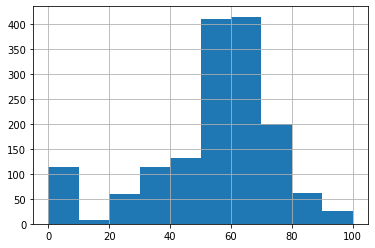

In [86]:
BT_SMA_2018['Win Rate [%]'].hist()

In [87]:
# Numbre of stock who more than 50% of succeful trades
len(BT_SMA_2018['Win Rate [%]'].loc[BT_SMA_2018['Win Rate [%]']>=50]) 

1112

#### Backtest BBANDS

In [63]:
BT_WR_BB_2018=[]
BT_VOL_BB_2018=[]
BT_ShR_BB_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],BBand,2017)
        BT_WR_BB_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_BB_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_BB_2018.append(bt_wr["Sharpe Ratio"])
    except:
        BT_WR_BB_2018.append(np.NAN)
        BT_VOL_BB_2018.append(np.NAN)
        BT_ShR_BB_2018.append(np.NAN)

c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gmean_day_return)**2)**annual_trading_days - (1 + gmean_day_return)**(2*annual_trading_days)) * 100  # noqa: E501
C:\Users\Zakaria Bouchegoura\AppData\Local\Temp\ipykernel_7328\281282468.py:12: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(STOCK.loc[STOCK['year']>year], STRATEGY,
c:\Users\Zakaria Bouchegoura\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_stats.py:114: RuntimeWarning: overflow encountered in double_scalars
  s.loc['Volatility (Ann.) [%]'] = np.sqrt((day_returns.var(ddof=int(bool(day_returns.shape))) + (1 + gm

In [64]:
BT_BB_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_BB_2018,BT_VOL_BB_2018,BT_ShR_BB_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio'])
BT_BB_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio
0,AAL,55.000000,93.507790,0.460064
1,AAME,40.000000,127.570253,0.000000
2,AAOI,37.878788,48.369168,0.000000
3,AAON,37.500000,34.947207,0.000000
4,AAPL,37.662338,24.636003,0.000000
...,...,...,...,...
1604,ZEUS,38.709677,44.942638,0.000000
1605,ZION,43.283582,37.393155,0.000000
1606,ZNGA,41.666667,34.340153,0.000000
1607,ZOES,63.636364,182.371328,1.078308


<AxesSubplot:>

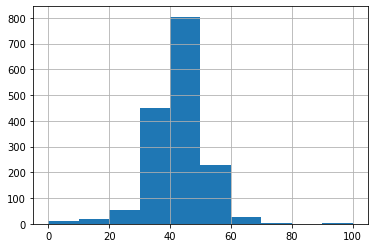

In [65]:
BT_BB_2018['Win Rate [%]'].hist()

In [ ]:
# Numbre of stock who more than 50% of succeful trades
len(BT_BB_2018['Win Rate [%]'].loc[BT_BB_2018['Win Rate [%]']>=50]) 

#### Backtest BBAND-RSI

In [ ]:
BT_WR_BB_RSI_2018=[]
BT_VOL_BB_RSI_2018=[]
BT_ShR_BB_RSI_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],BBand_RSI,2017)
        BT_WR_BB_RSI_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_BB_RSI_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_BB_RSI_2018.append(bt_wr["Sharpe Ratio"])
    except:
        BT_WR_BB_RSI_2018.append(np.NAN)
        BT_VOL_BB_RSI_2018.append(np.NAN)
        BT_ShR_BB_RSI_2018.append(np.NAN)

In [67]:
BT_BB_RSI_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_BB_RSI_2018,BT_VOL_BB_RSI_2018,BT_ShR_BB_RSI_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio'])
BT_BB_RSI_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio
0,AAL,22.222222,50.441722,0.000000
1,AAME,50.000000,9.260301,0.062049
2,AAOI,60.000000,70.165101,0.189744
3,AAON,37.500000,32.942331,0.000000
4,AAPL,16.666667,22.151922,0.000000
...,...,...,...,...
1604,ZEUS,37.500000,75.400129,0.077017
1605,ZION,80.000000,45.434644,0.382341
1606,ZNGA,0.000000,231.131359,0.000000
1607,ZOES,100.000000,63.998667,0.886715


<AxesSubplot:>

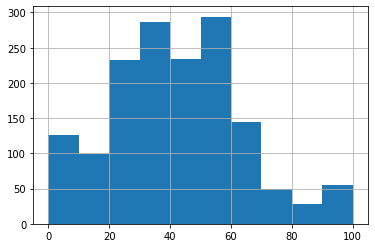

In [68]:
BT_BB_RSI_2018['Win Rate [%]'].hist()

In [ ]:
# Numbre of stock who more than 50% of succeful trades
len(BT_BB_RSI_2018['Win Rate [%]'].loc[BT_BB_RSI_2018['Win Rate [%]']>=50]) 

#### Backtest Tradepro

In [ ]:
BT_WR_TP_2018=[]
BT_VOL_TP_2018=[]
BT_ShR_TP_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],Tradepro,2017)
        BT_WR_TP_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_TP_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_TP_2018.append(bt_wr["Sharpe Ratio"])
    except:
        BT_WR_TP_2018.append(np.NAN)
        BT_VOL_TP_2018.append(np.NAN)
        BT_ShR_TP_2018.append(np.NAN)

In [70]:
BT_TP_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_TP_2018,BT_VOL_TP_2018,BT_ShR_TP_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio'])
BT_TP_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio
0,AAL,34.615385,19.639388,0.000000
1,AAME,61.764706,49.614654,0.207653
2,AAOI,57.142857,18.749532,0.000000
3,AAON,67.924528,19.846037,0.646627
4,AAPL,71.604938,18.139730,0.832469
...,...,...,...,...
1604,ZEUS,63.888889,39.213663,0.661374
1605,ZION,66.666667,16.983301,0.074424
1606,ZNGA,68.750000,22.044408,0.111017
1607,ZOES,50.000000,11.038431,0.000000


<AxesSubplot:>

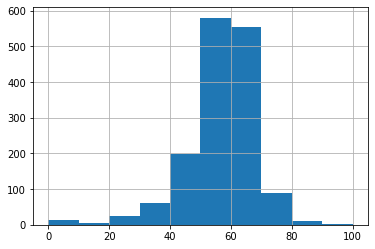

In [71]:
BT_TP_2018['Win Rate [%]'].hist()

In [81]:
# Numbre of stock who more than 50% of succeful trades
len(BT_TP_2018['Win Rate [%]'].loc[BT_TP_2018['Win Rate [%]']>=50]) 

1236

In [ ]:
BT_WR_ST_2018=[]
BT_VOL_ST_2018=[]
BT_ShR_ST_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],SuperTrend,2017)
        BT_WR_ST_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_ST_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_ST_2018.append(bt_wr["Sharpe Ratio"])
    except:
        BT_WR_ST_2018.append(np.NAN)
        BT_VOL_ST_2018.append(np.NAN)
        BT_ShR_ST_2018.append(np.NAN)

In [73]:
BT_ST_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_ST_2018,BT_VOL_ST_2018,BT_ShR_ST_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio'])
BT_ST_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio
0,AAL,63.157895,215.991083,0.000000
1,AAME,14.285714,111.933606,0.000000
2,AAOI,61.538462,64.603505,0.000000
3,AAON,71.428571,37.614818,0.581525
4,AAPL,55.555556,47.811235,0.000000
...,...,...,...,...
1604,ZEUS,16.666667,140.594551,0.000000
1605,ZION,64.285714,38.620373,0.000000
1606,ZNGA,73.684211,43.376303,0.073587
1607,ZOES,50.000000,60.625955,0.077526


<AxesSubplot:>

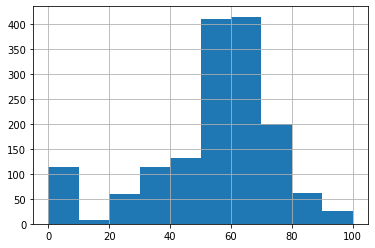

In [74]:
BT_ST_2018['Win Rate [%]'].hist()

In [ ]:
# Numbre of stock who more than 50% of succeful trades
len(BT_ST_2018['Win Rate [%]'].loc[BT_ST_2018['Win Rate [%]']>=50]) 

#### Backtesting Ichimuko

In [ ]:
BT_WR_IK_2018=[]
BT_VOL_IK_2018=[]
BT_ShR_IK_2018=[]
for stock in datasets.keys() :
    try:
        bt_wr=backtester(datasets[stock],Ichimuko,2017)
        BT_WR_IK_2018.append(bt_wr["Win Rate [%]"])
        BT_VOL_IK_2018.append(bt_wr["Volatility (Ann.) [%]"])
        BT_ShR_IK_2018.append(bt_wr["Sharpe Ratio"])
    except:
        BT_WR_IK_2018.append(np.NAN)
        BT_VOL_IK_2018.append(np.NAN)
        BT_ShR_IK_2018.append(np.NAN)

In [76]:
BT_IK_2018 = pd.DataFrame(list(zip(list(datasets.keys()), BT_WR_IK_2018,BT_VOL_IK_2018,BT_ShR_IK_2018)),
               columns =['Stock', 'Win Rate [%]','Volatility (Ann.) [%]','Sharpe Ratio'])
BT_IK_2018

,Stock,Win Rate [%],Volatility (Ann.) [%],Sharpe Ratio
0,AAL,38.775510,54.159465,0.000000
1,AAME,52.173913,116.684766,0.023807
2,AAOI,45.833333,40.967230,0.000000
3,AAON,58.064516,33.067034,0.067367
4,AAPL,58.064516,40.786723,0.807445
...,...,...,...,...
1604,ZEUS,60.526316,68.154436,0.241957
1605,ZION,37.931034,38.338146,0.051476
1606,ZNGA,56.756757,40.304875,0.160705
1607,ZOES,75.000000,62.461377,0.802872


<AxesSubplot:>

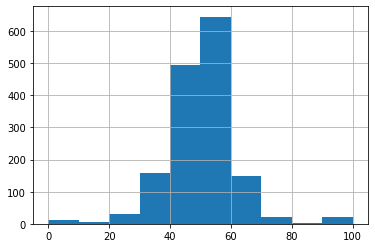

In [77]:
BT_IK_2018['Win Rate [%]'].hist()

In [ ]:
# Numbre of stock who more than 50% of succeful trades
len(BT_IK_2018['Win Rate [%]'].loc[BT_IK_2018['Win Rate [%]']>=50]) 

Conclsuion :

respecting the criteria of our studies, we find that the Tradepro strategy significantly describes the general behavior of the actions with a win rate greater than 50% for 1246 of the 1609 actions